In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import plot_roc_curve, roc_auc_score, roc_curve

First we are going to load the dataset, which is the accepted files from The Lending Club published in Kaggle data science contest platform as public pseudonymised files in compressed csv format. The information can be downloaded from https://www.kaggle.com/datasets/wordsforthewise/lending-club?resource=download

In [3]:
df=pd.read_csv('accepted_2007_to_2018Q4.csv.gz', compression='gzip')
df.info() # We can see that our data has 2.26 million observations with 151 variables

c:\Users\jjsal\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [4]:
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


### Time span of the dataset

Let's start by analising the colum `issue_d` which is the month of funding. This will enable us to understand how the credits are spread over time. Let's see how this column is formatted.

In [10]:
df.issue_d.describe()

count      2260668
unique         139
top       Mar-2016
freq         61992
Name: issue_d, dtype: object

In [7]:
df['issue_d'].value_counts()

Mar-2016    61992
Oct-2015    48631
May-2018    46311
Oct-2018    46305
Aug-2018    46079
            ...  
Aug-2007       74
Jul-2007       63
Sep-2008       57
Sep-2007       53
Jun-2007       24
Name: issue_d, Length: 139, dtype: int64

So we see inmediately that we will have an issue, as this is not formatted as a Date objet, but more like a text we can read. 

In [11]:
df['issue_ty'] = df['issue_d'].str[-4:]
df.dropna(subset=['issue_ty'], inplace=True)
df['issue_ty'] = df['issue_ty'].astype(str).astype(int)
df['issue_ty'].value_counts()

2018    495242
2017    443579
2016    434407
2015    421095
2014    235629
2013    134814
2012     53367
2011     21721
2010     12537
2009      5281
2008      2393
2007       603
Name: issue_ty, dtype: int64

Text(0, 0.5, 'Frequency')

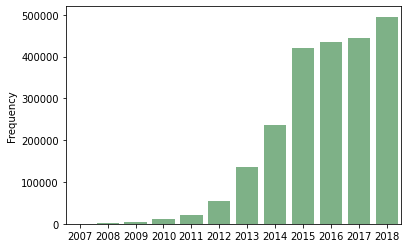

In [42]:
plot=sns.countplot(x=df.issue_ty, color='#76B982')
plot.set_xlabel(None)
plot.set_ylabel('Frequency')

<AxesSubplot:xlabel='int_rate', ylabel='Density'>

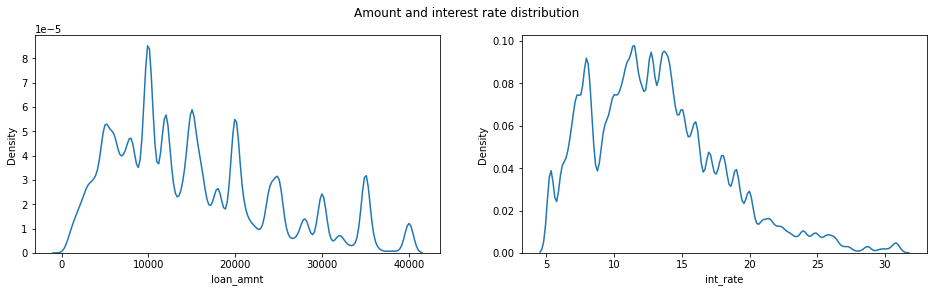

In [53]:
plot2, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))
plot2.suptitle('Amount and interest rate distribution')
sns.kdeplot(ax=ax1, x=df.loan_amnt)
sns.kdeplot(ax=ax2, x=df.int_rate)

In [56]:
df['termM']=df['term'].str[:3].astype(int)

In [57]:
df.termM.value_counts()

36    1609754
60     650914
Name: termM, dtype: int64

# Credit Model
Target is to define a credti score model that will evaluate what is the probability a credit will be defaulte. We are going to look at the `loan_status` column to give us this information.

In [58]:
df['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

So interesting different values.
* `fully paid` means we have no default, although a more in depth work would check this in more detail.
* `Current` means credit is on-going and hasn't presented any problems. No Default.
* `Charged off` means credit had been sent to losses because of a default.
* etc.

To build a score we need a binary categorical approach to this variable: Defaulted Yes or No. We will regroup these categories and build a new column `default` that will represent the target of our score.

In [60]:
isdefault=['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']
df['default']=df['loan_status'].isin(isdefault)
df['default'].value_counts()

False    1969841
True      290827
Name: default, dtype: int64

In [65]:
drate=df['default'].value_counts()[True]/df.shape[0]*100
print("Default Rate: {0:.2f}%".format(drate))

Default Rate: 12.86%


The default rate is high, but we have to recall that:
* This is crowlending data, so these site attracts typically more risky clients, who had been refused credits by banks.
* This is a lifetime default value, minurs the bias form on-going credits

## Features of the score
Now we will analise

### Credit bureau risk grading
there is s

In [66]:
df['grade'].value_counts()

B    663557
C    650053
A    433027
D    324424
E    135639
F     41800
G     12168
Name: grade, dtype: int64

In [67]:
df['sub_grade'].value_counts()

C1    145903
B5    140288
B4    139793
B3    131514
C2    131116
C3    129193
C4    127115
B2    126621
B1    125341
C5    116726
A5    107617
A4     95874
A1     86790
D1     81787
A3     73184
D2     72899
A2     69562
D3     64819
D4     56896
D5     48023
E1     33573
E2     29924
E3     26708
E4     22763
E5     22671
F1     13413
F2      9305
F3      7791
F4      6124
F5      5167
G1      4106
G2      2688
G3      2094
G4      1712
G5      1568
Name: sub_grade, dtype: int64

<AxesSubplot:xlabel='default', ylabel='sub_grade'>

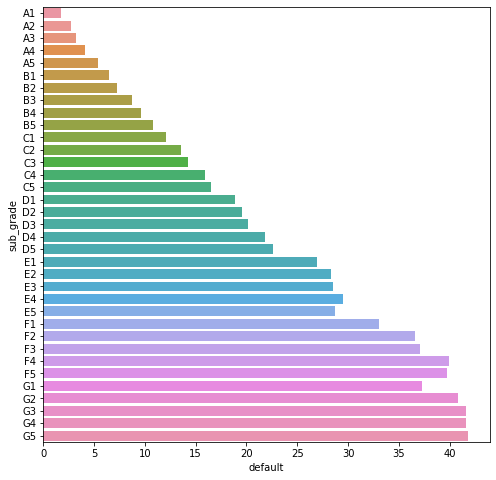

In [87]:
def_by_subgrade=(df.groupby('sub_grade')['default'].mean()*100) 
plot3, ax = plt.subplots(figsize=(8, 8))
sns.barplot(ax=ax, y=def_by_subgrade.index, x=def_by_subgrade)

In [92]:
sub_grade_list = list(df['sub_grade'].unique())
sub_grade_list.sort()
sub_grade_map = dict(zip(sub_grade_list, list(range(1,len(sub_grade_list)+1))))
print(sub_grade_map)

{'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5, 'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10, 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15, 'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20, 'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25, 'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30, 'G1': 31, 'G2': 32, 'G3': 33, 'G4': 34, 'G5': 35}


In [93]:
df['sub_grade'].sample(10)

134327     B3
1432568    C1
1995219    B3
2106235    A4
516281     C1
1937813    C1
1591770    C4
883828     B4
2056322    A5
1875511    B1
Name: sub_grade, dtype: object

In [94]:
df.replace({'sub_grade':sub_grade_map}, inplace=True)
df['sub_grade'].sample(10)

285754     11
508430      6
1858159     6
513570      3
2054342    16
1013179     1
1570700     6
774614      6
1127046    19
596239     14
Name: sub_grade, dtype: int64

In [95]:
df['sub_grade'].unique()

array([14, 11,  9, 15, 26, 13,  7,  6,  2, 10, 12, 22,  4, 23,  1, 19, 28,
       16,  8, 24, 18, 17, 20,  5, 27, 21, 30, 25,  3, 32, 31, 33, 34, 29,
       35], dtype=int64)

In [96]:
features_name=[]

In [97]:
features_name.append('sub_grade')

<AxesSubplot:xlabel='annual_inc', ylabel='Density'>

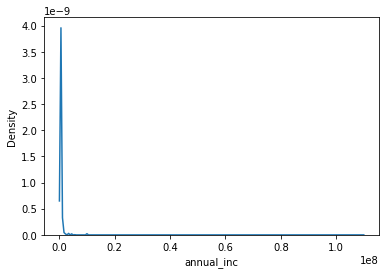

In [98]:
sns.kdeplot(df['annual_inc'])